# Inventory Optimization: Scenario Analysis (Service Level vs Inventory)

This notebook evaluates inventory policy scenarios using demand history to compare
service performance (stockouts) against inventory levels (holding cost proxy).


# 1. Imports and Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv("../data/inventory_data.csv")
df["date"] = pd.to_datetime(df["date"])
df.head()


,date,sku,demand,inventory_level,stockout,lead_time_days
0,2024-01-01,SKU_A,23,477,0,9
1,2024-01-02,SKU_A,19,458,0,5
2,2024-01-03,SKU_A,26,432,0,5
3,2024-01-04,SKU_A,25,407,0,6
4,2024-01-05,SKU_A,15,392,0,8


# 2. Prepare demand series per SKU

In [2]:
skus = df["sku"].unique().tolist()

# Use daily demand per SKU sorted by date
demand_by_sku = {
    sku: df[df["sku"] == sku].sort_values("date")["demand"].to_numpy()
    for sku in skus
}

# Use a single lead time per SKU (average lead time from dataset)
lead_time_by_sku = {
    sku: int(round(df[df["sku"] == sku]["lead_time_days"].mean()))
    for sku in skus
}

lead_time_by_sku


{'SKU_A': 6, 'SKU_B': 6, 'SKU_C': 6}

# 3. Inventory policy simulator

Simulate a simple inventory control policy:
- Review daily.
- If inventory position (on-hand + on-order) ≤ ROP, place an order to raise position to Order-Up-To level.
- The order arrives after a lead time (L days).

In [3]:
def simulate_policy(demand, lead_time, rop, order_up_to, initial_on_hand=500):
    """
    Simple (s, S) policy simulation:
    - demand: array of daily demand
    - lead_time: integer days
    - rop: reorder point (s)
    - order_up_to: order-up-to level (S)
    """
    n = len(demand)
    on_hand = initial_on_hand
    on_order = []  # list of tuples (arrival_day, qty)
    
    stockout_days = 0
    total_demand = 0
    total_fulfilled = 0
    on_hand_history = []
    orders_placed = 0
    
    for day in range(n):
        # Receive orders arriving today
        if on_order:
            arrived = [o for o in on_order if o[0] == day]
            if arrived:
                on_hand += sum(qty for _, qty in arrived)
            on_order = [o for o in on_order if o[0] != day]
        
        d = int(demand[day])
        total_demand += d
        
        # Fulfill demand
        fulfilled = min(on_hand, d)
        on_hand -= fulfilled
        total_fulfilled += fulfilled
        
        if fulfilled < d:
            stockout_days += 1
        
        on_hand_history.append(on_hand)
        
        # Inventory position = on_hand + on_order_qty
        position = on_hand + sum(qty for _, qty in on_order)
        
        # Reorder if at/below ROP
        if position <= rop:
            qty = max(0, order_up_to - position)
            if qty > 0:
                on_order.append((day + lead_time, qty))
                orders_placed += 1
    
    avg_on_hand = float(np.mean(on_hand_history))
    service_level_fill_rate = (total_fulfilled / total_demand) if total_demand else 1.0
    stockout_rate_days = stockout_days / n if n else 0.0
    
    return {
        "avg_on_hand": avg_on_hand,
        "stockout_rate_days": stockout_rate_days,
        "fill_rate": service_level_fill_rate,
        "orders_placed": orders_placed
    }



# 4. Define baseline and scenarios

Compute ROP using:
- ROP = μ·L + k·σ·sqrt(L)
- Order-up-to: S = ROP + μ·R (review period R=7 days)

In [4]:
review_period = 7  # days

scenario_k = {
    "Low safety (k=0.5)": 0.5,
    "Baseline (k=1.0)": 1.0,
    "High safety (k=1.5)": 1.5,
    "Very high safety (k=2.0)": 2.0,
}

results = []

for sku in skus:
    demand = demand_by_sku[sku]
    L = lead_time_by_sku[sku]
    
    mu = float(np.mean(demand))
    sigma = float(np.std(demand, ddof=0))
    
    for scenario_name, k in scenario_k.items():
        rop = mu * L + k * sigma * np.sqrt(L)
        order_up_to = rop + mu * review_period
        
        metrics = simulate_policy(
            demand=demand,
            lead_time=L,
            rop=rop,
            order_up_to=order_up_to,
            initial_on_hand=500
        )
        
        results.append({
            "sku": sku,
            "lead_time_days": L,
            "scenario": scenario_name,
            "k": k,
            "rop": round(rop, 1),
            "order_up_to": round(order_up_to, 1),
            "avg_on_hand": round(metrics["avg_on_hand"], 1),
            "stockout_rate_days_pct": round(metrics["stockout_rate_days"] * 100, 2),
            "fill_rate_pct": round(metrics["fill_rate"] * 100, 2),
            "orders_placed": metrics["orders_placed"]
        })

results_df = pd.DataFrame(results)
results_df


,sku,lead_time_days,scenario,k,rop,order_up_to,avg_on_hand,stockout_rate_days_pct,fill_rate_pct,orders_placed
0,SKU_A,6,Low safety (k=0.5),0.5,126.0,267.1,116.4,1.67,99.72,14
1,SKU_A,6,Baseline (k=1.0),1.0,131.1,272.2,119.4,0.83,99.97,14
2,SKU_A,6,High safety (k=1.5),1.5,136.2,277.3,123.4,0.00,100.00,14
3,SKU_A,6,Very high safety (k=2.0),2.0,141.3,282.4,127.5,0.00,100.00,14
4,SKU_B,6,Low safety (k=0.5),0.5,122.8,259.8,114.7,2.50,99.50,14
5,SKU_B,6,Baseline (k=1.0),1.0,128.2,265.1,118.5,0.83,99.84,14
6,SKU_B,6,High safety (k=1.5),1.5,133.6,270.5,124.8,0.00,100.00,14
7,SKU_B,6,Very high safety (k=2.0),2.0,138.9,275.9,129.1,0.00,100.00,14
8,SKU_C,6,Low safety (k=0.5),0.5,125.2,265.3,114.9,0.00,100.00,14
9,SKU_C,6,Baseline (k=1.0),1.0,130.4,270.5,119.1,0.00,100.00,14


# 5. Summary table

In [5]:
summary = results_df.sort_values(["sku", "k"])[
    ["sku", "scenario", "stockout_rate_days_pct", "fill_rate_pct", "avg_on_hand", "orders_placed"]
]
summary


,sku,scenario,stockout_rate_days_pct,fill_rate_pct,avg_on_hand,orders_placed
0,SKU_A,Low safety (k=0.5),1.67,99.72,116.4,14
1,SKU_A,Baseline (k=1.0),0.83,99.97,119.4,14
2,SKU_A,High safety (k=1.5),0.00,100.00,123.4,14
3,SKU_A,Very high safety (k=2.0),0.00,100.00,127.5,14
4,SKU_B,Low safety (k=0.5),2.50,99.50,114.7,14
5,SKU_B,Baseline (k=1.0),0.83,99.84,118.5,14
6,SKU_B,High safety (k=1.5),0.00,100.00,124.8,14
7,SKU_B,Very high safety (k=2.0),0.00,100.00,129.1,14
8,SKU_C,Low safety (k=0.5),0.00,100.00,114.9,14
9,SKU_C,Baseline (k=1.0),0.00,100.00,119.1,14


# 6. Visualization: trade-off chart

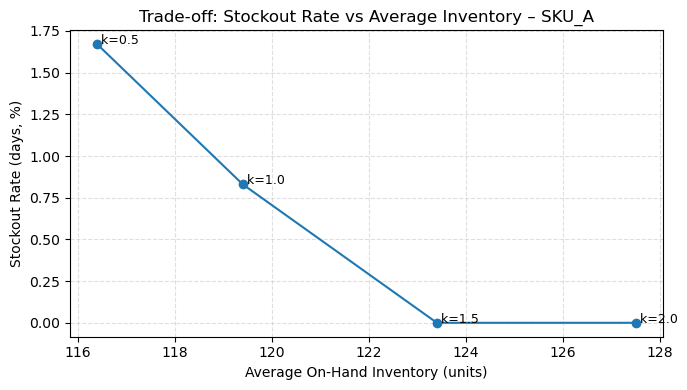

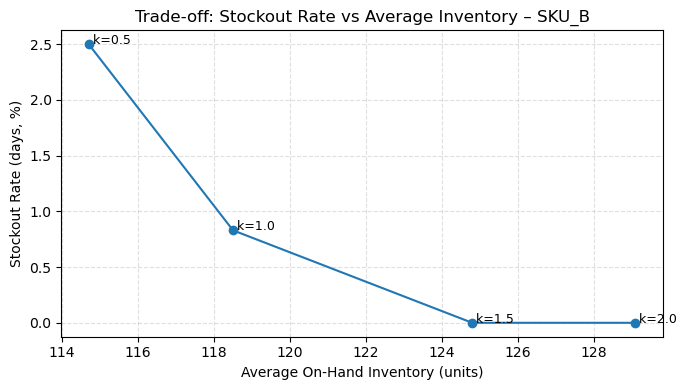

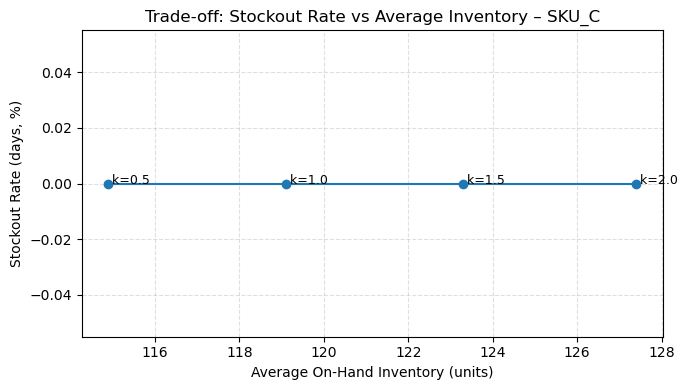

In [6]:
for sku in skus:
    sub = results_df[results_df["sku"] == sku].sort_values("k")
    
    plt.figure(figsize=(7, 4))
    plt.plot(sub["avg_on_hand"], sub["stockout_rate_days_pct"], marker="o")
    
    for _, r in sub.iterrows():
        plt.text(r["avg_on_hand"], r["stockout_rate_days_pct"], f' k={r["k"]}', fontsize=9)
    
    plt.title(f"Trade-off: Stockout Rate vs Average Inventory – {sku}")
    plt.xlabel("Average On-Hand Inventory (units)")
    plt.ylabel("Stockout Rate (days, %)")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


## Conclusion

This scenario analysis shows a clear trade-off between service performance and inventory levels:

- Increasing safety factor **k** generally reduces stockout risk and improves fill rate.
- Higher service levels require higher average on-hand inventory (holding cost proxy).
- The recommended policy depends on business priorities (service-level targets vs cost constraints).

### Managerial Insights

- SKU_A shows a strong trade-off between service level and inventory, suggesting safety stock increases should be evaluated against holding cost.
- SKU_B achieves most service improvements at moderate safety levels, indicating diminishing returns for higher inventory buffers.
- SKU_C experiences no stockouts across all scenarios, suggesting potential overstocking and an opportunity to reduce inventory without service risk.

Overall, the analysis highlights the importance of differentiated inventory policies by SKU rather than a one-size-fits-all approach.